In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from xgboost import XGBClassifier,XGBRegressor
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from scipy.optimize import curve_fit
import json

In [121]:
df = pd.read_feather('big_frame_4.feather')

In [122]:
x_train,x_test,y_train,y_test = train_test_split(df.drop('DEFAULT',axis = 1).values,df['DEFAULT'].values,test_size = 0.25)

In [123]:
(1 - df['DEFAULT']).sum() / df['DEFAULT'].sum()

14.01393878430809

In [124]:
from sklearn.metrics import make_scorer

def proba_plot(real,pred,step):
    y = []
    x = []
    i = 0
    while i < len(real):
        ones = len(pred[(pred < i + step) & (pred >= i) & (real == 1)])
        all = len(pred[(pred < i + step) & (pred >= i)])
        if all == 0:
            break
        y.append(ones / all)
        x.append(i + (step / 2))
        i += step
    plt.plot(x,y)
    
def proba_data(real,pred,step):
    y = []
    x = []
    i = 0
    while i < len(real):
        ones = len(pred[(pred < i + step) & (pred >= i) & (real == 1)])
        all = len(pred[(pred < i + step) & (pred >= i)])
        if all == 0:
            break
        y.append(ones / all)
        x.append(i + (step / 2))
        i += step
    return x,y

def metric(real,pred):
    return (pred[real == 1].sum() * 14 + (1 - pred[real == 0]).sum()) / (real.sum() * 14 + len(real[real == 0]))

scorer = make_scorer(metric)

In [125]:
print(metric(y_test,np.zeros(y_test.shape)))
print(metric(y_test,np.ones(y_test.shape)))

0.5056538126993332
0.4943461873006669


Score: 0.6761636178228744


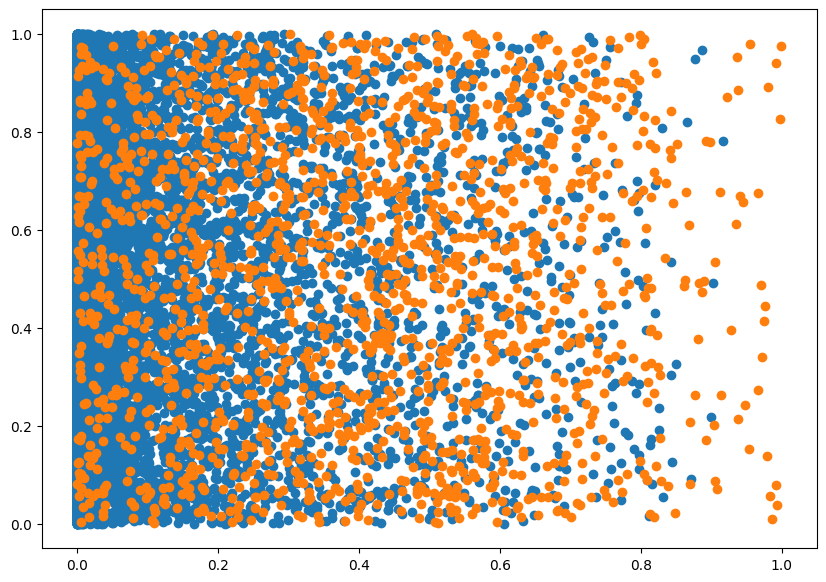

In [126]:
xgb_model = XGBClassifier().fit(x_train, y_train)
prediction = xgb_model.predict_proba(x_test)[:,1]
print('Score:',metric(y_test,prediction))
plt.figure(figsize = (10,7))
_ = plt.scatter(prediction[y_test == 0],np.random.rand(len(prediction[y_test == 0])))
_ = plt.scatter(prediction[y_test == 1],np.random.rand(len(prediction[y_test == 1])))

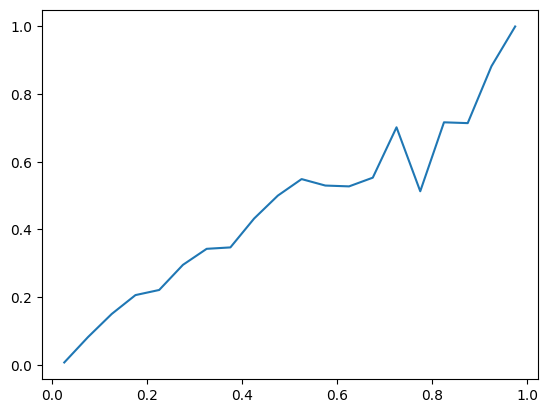

In [127]:
proba_plot(y_test,prediction,0.05)

Score: 0.7269868489273223


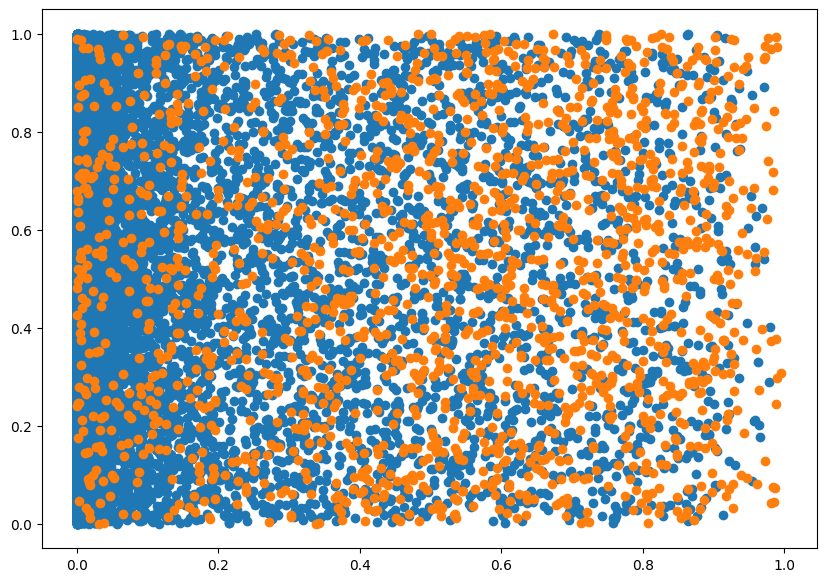

In [128]:
smote = SMOTE()
x_smote, y_smote = smote.fit_resample(x_train, y_train)
xgb_model = XGBClassifier().fit(x_smote, y_smote)
prediction = xgb_model.predict_proba(x_test)[:,1]
print('Score:',metric(y_test,prediction))
plt.figure(figsize = (10,7))
_ = plt.scatter(prediction[y_test == 0],np.random.rand(len(prediction[y_test == 0])))
_ = plt.scatter(prediction[y_test == 1],np.random.rand(len(prediction[y_test == 1])))

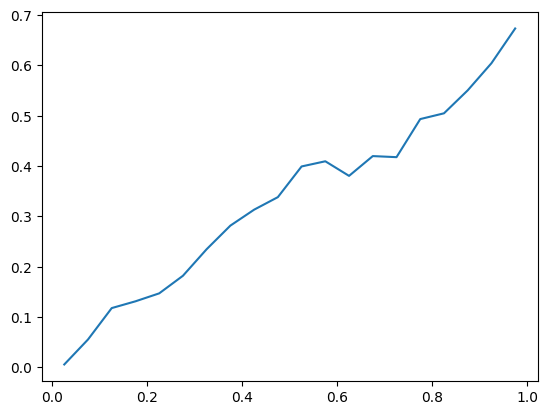

In [129]:
proba_plot(y_test,prediction,0.05)

In [30]:
x,y = df.drop('DEFAULT',axis = 1).values,df['DEFAULT'].values
cv = KFold(n_splits = 4)
param_grid = {'scale_pos_weight':list(range(1,251,5))}
model = XGBRegressor()
grid = GridSearchCV(estimator = model, param_grid = param_grid, n_jobs = -1, scoring = scorer,verbose = 3,cv = cv)
grid_result = grid.fit(x,y)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


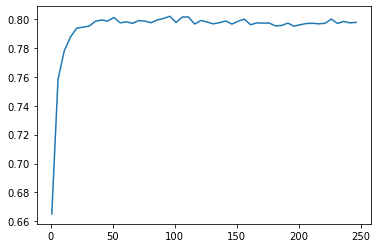

In [50]:
scores = grid_result.cv_results_['mean_test_score']
plt.plot(list(range(1,251,5)),scores)

Score: 0.7739483417327228


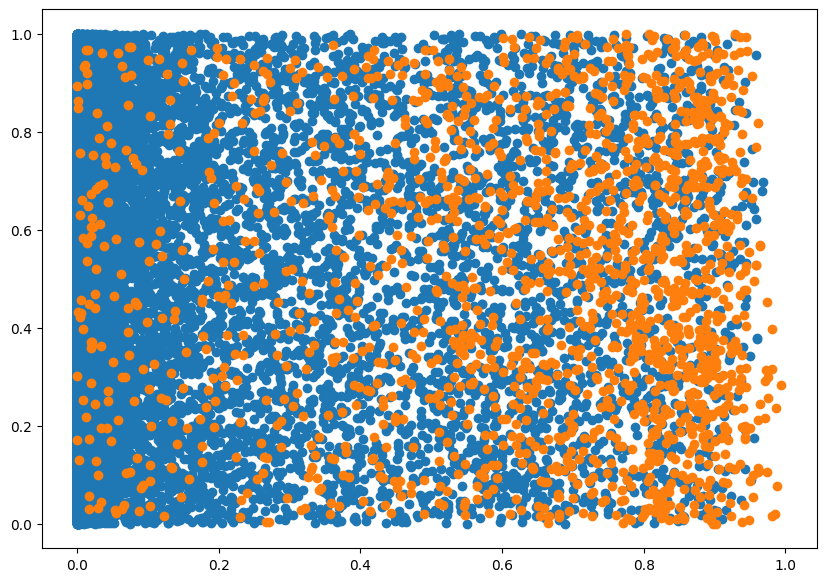

In [130]:
xgb_model = XGBClassifier(scale_pos_weight = 5).fit(x_train, y_train)
prediction = xgb_model.predict_proba(x_test)[:,1]
print('Score:',metric(y_test,prediction))
plt.figure(figsize = (10,7))
_ = plt.scatter(prediction[y_test == 0],np.random.rand(len(prediction[y_test == 0])))
_ = plt.scatter(prediction[y_test == 1],np.random.rand(len(prediction[y_test == 1])))

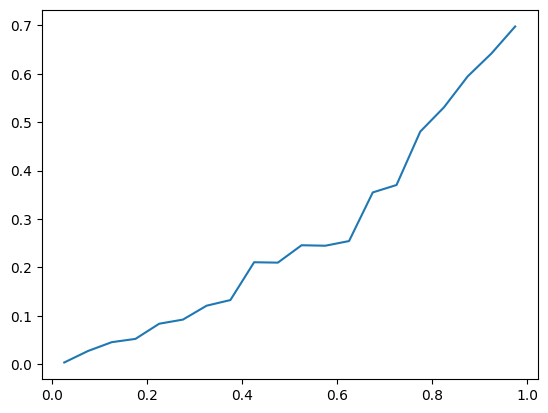

In [131]:
proba_plot(y_test,prediction,0.05)

Score: 0.7222129026383812


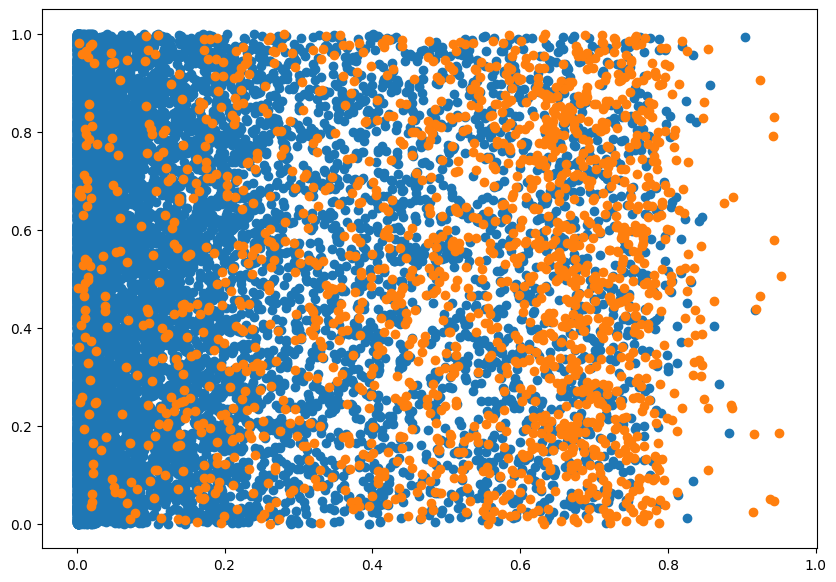

In [145]:
xgb_model = XGBClassifier(scale_pos_weight = 2,max_depth = 2,eta = .4).fit(x_train, y_train)
prediction = xgb_model.predict_proba(x_test)[:,1]
print('Score:',metric(y_test,prediction))
plt.figure(figsize = (10,7))
_ = plt.scatter(prediction[y_test == 0],np.random.rand(len(prediction[y_test == 0])))
_ = plt.scatter(prediction[y_test == 1],np.random.rand(len(prediction[y_test == 1])))


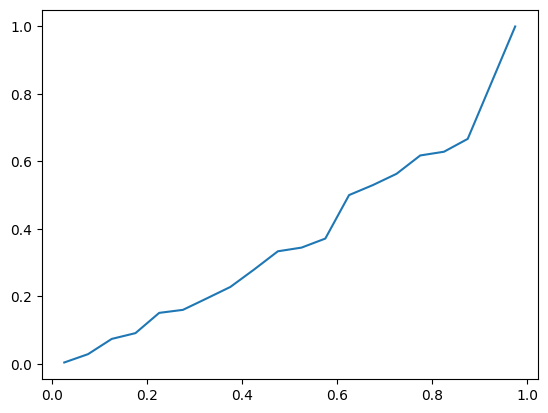

In [146]:
proba_plot(y_test,prediction,0.05)

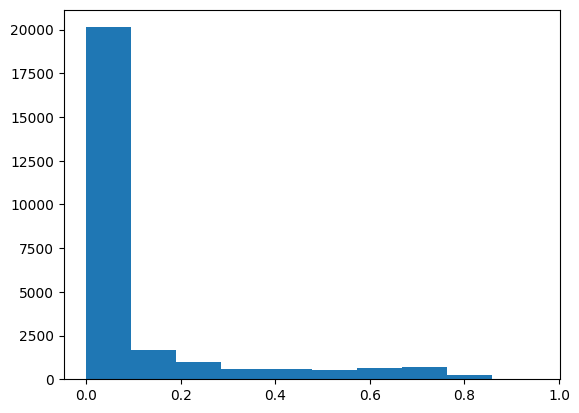

In [147]:
plt.hist(prediction)
plt.show()

In [148]:
xgb_model.save_model('model_load.json')

In [149]:
model = XGBClassifier()
model.load_model('model_load.json')

In [150]:
def square(x,a,b,c):
    return ((x ** 2) * a) + (x * b) + c

In [151]:
probx,proby = proba_data(y_test,prediction,0.05)

In [152]:
popt = curve_fit(square,probx,proby)[0]

In [153]:
curve_values = [square(x,*popt) for x in probx]

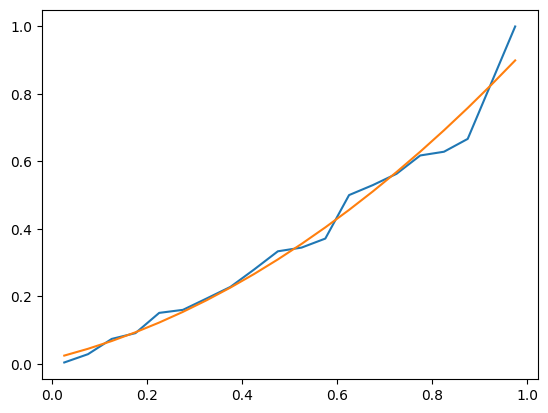

In [154]:
plt.plot(probx,proby)
plt.plot(probx,curve_values)
plt.show()

In [155]:
with open('coef.json','w') as file:
    json.dump(list(popt),file)